<h2><center> Quick, Draw! Doodle Recognition Challenge & CNNs</center> </h2>

### Let's see how CNNS the already proven model to image classification peforms in this challenge.

This is just a demonstration that's why im not using all the categories from the train set.

### Dependencies

In [1]:
import os
import ast
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

Using TensorFlow backend.


### Auxiliar functions

In [2]:
def drawing_to_np(drawing, shape=(28, 28)):
    # evaluates the drawing array
    drawing = eval(drawing)
    fig, ax = plt.subplots()
    for x,y in drawing:
        ax.plot(x, y, marker='.')
        ax.axis('off')        
    fig.canvas.draw()
    # Close figure so it won't get displayed while transforming the set
    plt.close(fig)
    # Convert images to numpy array
    np_drawing = np.array(fig.canvas.renderer._renderer)
    # Take only one channel
    np_drawing =np_drawing[:, :, 1]    
    # Normalize data
    np_drawing = np_drawing / 255.
    return cv2.resize(np_drawing, shape) # Resize array


def plot_metrics_primary(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

    ax1.plot(acc, label='Train Accuracy')
    ax1.plot(val_acc, label='Validation accuracy')
    ax1.legend(loc='best')
    ax1.set_title('Accuracy')

    ax2.plot(loss, label='Train loss')
    ax2.plot(val_loss, label='Validation loss')
    ax2.legend(loc='best')
    ax2.set_title('Loss')

    plt.xlabel('Epochs')
    
    
def plot_confusion_matrix(cnf_matrix, labels): 
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(20,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    plt.show()

### Load data

In [3]:
TRAIN_PATH = '../input/train_simplified/'
TEST_PATH = '../input/test_simplified.csv'
SUBMISSION_NAME = 'submission.csv'

train = pd.DataFrame()
for file in os.listdir(TRAIN_PATH)[:5]:
    train = train.append(pd.read_csv(TRAIN_PATH + file, usecols=[1, 5], nrows=2000))
# Shuffle data
train = shuffle(train, random_state=123)
test = pd.read_csv(TEST_PATH, usecols=[0, 2], nrows=100)

### Parameters

In [4]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 60
LEARNING_RATE = 0.001
N_CLASSES = train['word'].nunique()
HEIGHT = 28
WIDTH = 28
CHANNEL = 1

### Let's take a look at the raw data

In [5]:
print('Train set shape: ', train.shape)
print('Train set features: %s' % train.columns.values)
print('Train number of label categories: %s' % N_CLASSES)
train.head()

Train set shape:  (10000, 2)
Train set features: ['drawing' 'word']
Train number of label categories: 5


,drawing,word
656,"[[[32, 64, 95, 101, 108, 194, 210, 231], [131,...",house plant
445,"[[[49, 119, 199, 233, 241, 254, 254, 243, 141,...",sleeping bag
1505,"[[[169, 91, 63, 36, 3], [2, 90, 128, 174, 213]...",triangle
332,"[[[70, 54, 22, 0, 21, 37, 76, 111, 182, 189, 1...",sleeping bag
168,"[[[4, 4, 8, 15, 25, 45, 63, 166, 196, 224, 250...",bathtub


### Pre process

In [6]:
#Fixing label
train['word'] = train['word'].replace(' ', '_', regex=True)
# Get labels and one-hot encode them.
classes_names = train['word'].unique()
labels = pd.get_dummies(train['word']).values
train.drop(['word'], axis=1, inplace=True)
# Transform drawing into numpy arrays
train['drawing_np'] = train['drawing'].apply(drawing_to_np)
# Reshape arrays
train_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in train['drawing_np'].values])

In [7]:
train.head()

,drawing,drawing_np
656,"[[[32, 64, 95, 101, 108, 194, 210, 231], [131,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
445,"[[[49, 119, 199, 233, 241, 254, 254, 243, 141,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1505,"[[[169, 91, 63, 36, 3], [2, 90, 128, 174, 213]...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
332,"[[[70, 54, 22, 0, 21, 37, 76, 111, 182, 189, 1...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
168,"[[[4, 4, 8, 15, 25, 45, 63, 166, 196, 224, 250...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


### Split data in train and validation (90% ~ 10%)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(train_drawings, labels, test_size=0.1, random_state=1)

### Model

In [9]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5,5),padding='Same', activation='relu', input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Conv2D(32, kernel_size=(5,5),padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3),padding='Same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3),padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation = "softmax"))

optimizer = optimizers.adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
print('Dataset size: %s' % train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: (%s, %s, %s)' % (HEIGHT, WIDTH, CHANNEL))
model.summary()

Dataset size: 10000
Epochs: 60
Learning rate: 0.001
Batch size: 64
Input dimension: (28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
______________________________________________

In [11]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

Train on 9000 samples, validate on 1000 samples
Epoch 1/60
9000/9000 [==============================] - 10s 1ms/step - loss: 1.6111 - acc: 0.1963 - val_loss: 1.6096 - val_acc: 0.1860
Epoch 2/60
9000/9000 [==============================] - 3s 342us/step - loss: 1.6088 - acc: 0.2019 - val_loss: 1.5890 - val_acc: 0.3350
Epoch 3/60
9000/9000 [==============================] - 3s 341us/step - loss: 1.2237 - acc: 0.4956 - val_loss: 0.8936 - val_acc: 0.6860
Epoch 4/60
9000/9000 [==============================] - 3s 378us/step - loss: 0.8983 - acc: 0.6501 - val_loss: 0.7548 - val_acc: 0.7470
Epoch 5/60
9000/9000 [==============================] - 3s 349us/step - loss: 0.7715 - acc: 0.7122 - val_loss: 0.7162 - val_acc: 0.7340
Epoch 6/60
9000/9000 [==============================] - 3s 330us/step - loss: 0.7210 - acc: 0.7324 - val_loss: 0.6135 - val_acc: 0.7910
Epoch 7/60
9000/9000 [==============================] - 3s 339us/step - loss: 0.6771 - acc: 0.7551 - val_loss: 0.5997 - val_acc: 0.7870
E

9000/9000 [==============================] - 3s 337us/step - loss: 0.3200 - acc: 0.8779 - val_loss: 0.5505 - val_acc: 0.8350


Let's take a look at our model loss and accuracy training and validation graph.

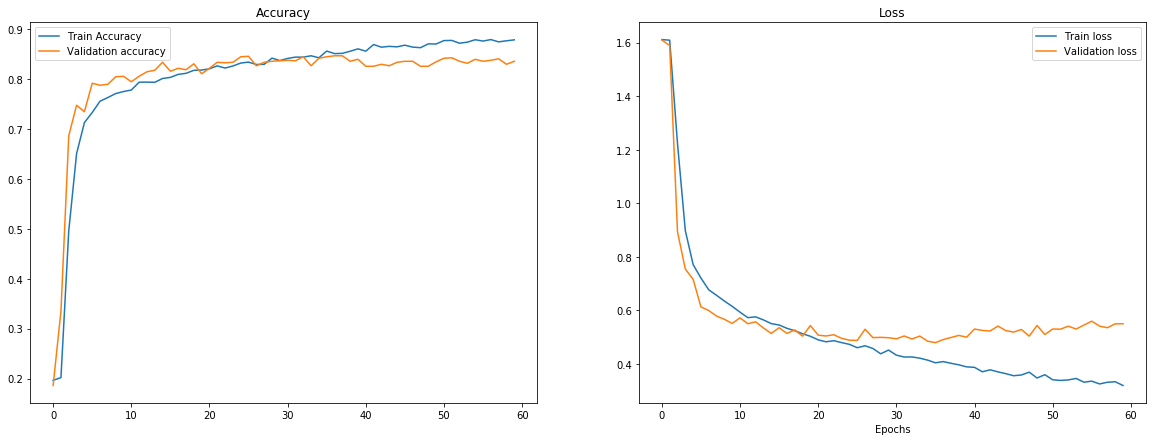

In [12]:
plot_metrics_primary(history.history['acc'], history.history['val_acc'], history.history['loss'], history.history['val_loss'])

A good way to evaluate a classification model is to take a look at the model confusion matrix, this way we can have a better insight on what our model is getting right and what not.

/opt/conda/lib/python3.6/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


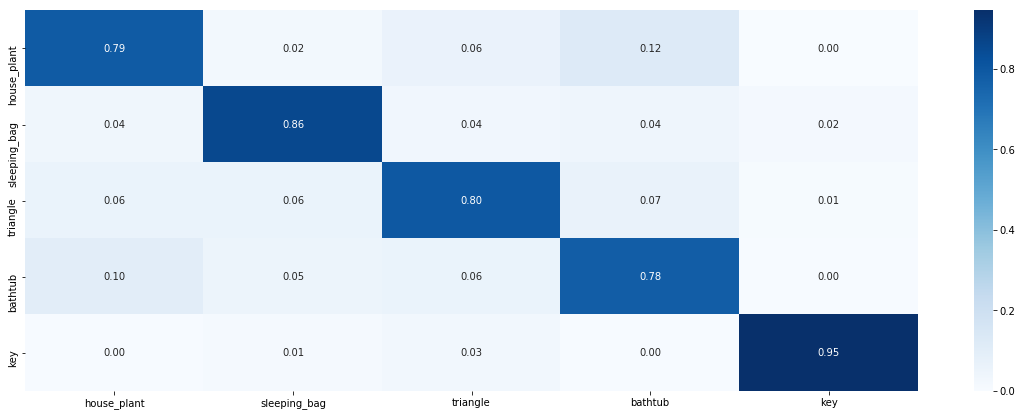

In [13]:
cnf_matrix = confusion_matrix(np.argmax(y_val, axis=1), model.predict_classes(x_val))
plot_confusion_matrix(cnf_matrix, classes_names)

Finally let's predict the test data and output our predictions.

### Process test

In [14]:
# Transform drawing into numpy arrays.
test['drawing_np'] = test['drawing'].apply(drawing_to_np)
# Reshape arrays.
test_drawings = np.asarray([x.reshape(HEIGHT, WIDTH, CHANNEL) for x in test['drawing_np'].values])

In [15]:
predictions = model.predict(test_drawings)
top_3_predictions = np.asarray([np.argpartition(pred, -3)[-3:] for pred in predictions])
top_3_predictions = ['%s %s %s' % (classes_names[pred[0]], classes_names[pred[1]], classes_names[pred[2]]) for pred in top_3_predictions]
test['word'] = top_3_predictions

In [16]:
submission = test[['key_id', 'word']]
submission.to_csv(SUBMISSION_NAME, index=False)
submission.head()

,key_id,word
0,9000003627287624,bathtub triangle house_plant
1,9000010688666847,triangle bathtub house_plant
2,9000023642890129,triangle sleeping_bag house_plant
3,9000038588854897,triangle sleeping_bag key
4,9000052667981386,bathtub triangle key
